<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>

# Proximal Policy Optimization

In this notebook, we are going to have a look at the Proximal Policy Optimization algorithm.

It is important to outline a couple of distinctive features between REINFORCE and PPO:
1. We are going to use a Critic model to estimate advantages.
2. PPO works with mini-batch SGD, therefore it is more efficient.
3. We can reuse the past trajectories, due to importance sampling.


The main class of the PPO looks very similar to REINFORCE, however, we add a critic network and its optimizer.

```python

class PPOAgent:
    def __init__(self, config=None):
        
        self.continuous = True if isinstance(self.env.action_space, Box) else False
        if self.continuous:
            self.num_outputs = self.env.action_space.shape[0] * 2
            self.action_dist_cls = GaussianDistribution
            self.env = ClipActionsWrapper(self.env)
        else:
            self.num_outputs = self.env.action_space.n
            self.action_dist_cls = CategoricalDistribution
        
        self.actor = build_actor_network(
            obs_shape=self.env.observation_space.shape,
            n_outputs=self.num_outputs,
            num_dim=config["num_dim_actor"],
            act_f=config["act_f_actor"],
            output_act_f="linear",
        )

        self.critic = build_critic_network(
            obs_shape=self.env.observation_space.shape,
            num_dim=config["num_dim_critic"],
            act_f=config["act_f_critic"],
        )

        self.actor_optimizer = optimizers.Adam(self.lr, epsilon=1e-5)
        self.critic_optimizer = optimizers.Adam(self.lr, epsilon=1e-5)
        ...
```

## Sampling Trajectories

The main distinction starts in the way we are going to collect the trajectories. Previously we did this with `sample_trajectory()` method. Now we only need to save the $ln(\pi_{old})$ into the memory. Additionally, once the trajectory is ready we also take the estimates of the value function. We do this on the whole trajectory to save computation time.


```python
class PPOAgent:
    def sample_trajectory(self):
        traj_dict = defaultdict(list)

        obs = self.env.reset()
        done = False
        score = 0
        # Run one episode
        while not done:
            action, log_p, action_dist_input = self.compute_action(obs)
            next_obs, reward, done, info = self.env.step(action)

            traj_dict[SampleBatch.OBS].append(obs)
            traj_dict[SampleBatch.ACTIONS].append(action)
            traj_dict[SampleBatch.DONES].append(done)
            traj_dict[SampleBatch.REWARDS].append(reward)
            traj_dict[SampleBatch.ACTION_DIST_INPUTS].append(action_dist_input)
            traj_dict[SampleBatch.ACTION_LOGP].append(log_p)

            obs = next_obs
            score += reward
        # Convert simple dictionary to SampleBatch
        sample_batch = SampleBatch(traj_dict)
        # Compute Value Estimates
        sample_batch[SampleBatch.VF_PREDS] = self.critic.predict(
            sample_batch[SampleBatch.OBS]
        )
        # Compute Advantages
        sample_batch = compute_advantages(
            sample_batch,
            last_r=0,
            gamma=self.gamma,
            lambda_=self.gae_lambda,
            use_critic=self.use_critic,
            use_gae=self.use_gae,
        )
        return sample_batch, score
```

### Calculating the advantages

#### Using GAE

You might also notice that we make use of `compute_advantages()` method here. It will extend each trajectory with advantage calculation. In our case, we are going to use GAE for advantage estimation. Since we always run the episode until completion the `last_r` will equal 0. (Different values of `last_r` are used when the episodes are too long or infinite. In this case, `last_r` will equal the value estimate in the last state. This allows to use of PPO in environments with arbitrary episode length.)

To calculate the advantages, we need to recal the formula of the TD-residual:
$$
\delta^V_t = R_t + \gamma V(S_{t+1}) - V(S_t)
$$

So what we need to subtract the value estimate of the state $V(S_t)$ from the discounted value estimate of the next state $\gamma V(S_{t+1})$ and add a reward in the current state $R_t$. Since we have all the reward and value estimates in one vector, we can just shift the value estimates one position up, discount them and subtract the unshifted vector.

```python
vpred_t = np.concatenate([rollout[SampleBatch.VF_PREDS], np.array([[last_r]])])
delta_t = rollout[SampleBatch.REWARDS] + gamma * vpred_t[1:] - vpred_t[:-1]
```
Remember that `last_r` in our case is always 0. This will yield the TD-residuals.

Next, we need to use the last formula to obtain advantages

$$
A^{GAE(\gamma,\lambda)} = \sum_{l=0}^\infty (\gamma\lambda)^l \delta^V_{t+l}
$$

So what is left to do is to multiply $\lambda$ and $\gamma$ and use the `discount_cumsum()` method we have defined earlier

```python
rollout[SampleBatch.ADVANTAGES] = discount_cumsum(delta_t, gamma * lambda_)

```

To calculate the targets for the next value updates we need to add the advantages and the old predictions. It makes sense because the advantages show us how good or bad was the estimates. This target is almost the same as the one used in DQN training!

$$
y_{target} = A^{GAE(\gamma,\lambda)} (S_t, A_t) + V(S_t) 
$$

```python
rollout[SampleBatch.VALUE_TARGETS] = rollout[SampleBatch.ADVANTAGES] + rollout[SampleBatch.VF_PREDS]
```
### Simple Advantage Estimation
In case we do not use GAE, the advantages calculation looks a lot simpler: the difference between real discounted return and the value estimates.

$$
A(S_t) = G(S_t) - V(S_t)
$$

```python

rewards_plus_v = np.concatenate([rollout[SampleBatch.REWARDS], np.array([[last_r]])])
discounted_returns = discount_cumsum(rewards_plus_v, gamma)[:-1]
rollout[SampleBatch.ADVANTAGES] = discounted_returns - rollout[SampleBatch.VF_PREDS]
       
```

And the targets of our Value function are the discounted returns themselves:
$$
y_{target} = G_t
$$
```python
 rollout[SampleBatch.VALUE_TARGETS] = discounted_returns
```


### Sampling a Training Batch

However, now we are not going to perform an update after each trajectory. We are going to save all of the trajectories in a training batch. The method `sample_batch()` does nothing more but concatenates all of the trajectories to one big training batch. The size of the training batch is a hyper-parameter defined earlier.

```python
class PPOAgent:
    def sample_batch(self):
        samples = []
        # collect trajectories untill training batch is full
        while num_steps < self.train_batch_size:
            trajectory, score = self.sample_trajectory()
            samples.append(trajectory)
            
        # concatenate all the trajectories together
        return SampleBatch.concat_samples(samples), batch_stats
```


## Policy Update

Now we are going to use the collected training batch and perform mini-batch stochastic gradient descent. For this we are going to write two methods: `train_op_actor` - to update the actor, and `train_op_critic()` - to update the critic.

### `train_actor_batch`

In this method we compute clipped Policy Gradient objective:

$$
J^{CLIP}(\theta) = \mathbb{E}\left[ \operatorname{min}(r(\theta)A_{\theta_{old}}(s, a), \operatorname{clip}(r(\theta), 1 - \varepsilon, 1 + \varepsilon)) A_{\theta_{old}}(s, a)\right] 
$$

And the entropy $H(s, \pi_\theta(.))$ to arrive at the actor loss:

$$
\mathcal{L}_{actor} = \mathbb{E}\left[J^{CLIP}(\theta) + c_2 * H(s, \pi_\theta(.))\right]
$$


```python
class PPOAgent:
    @tf.function
    def train_op_actor(
        self, obs_batch, action_old_batch, action_old_log_p_batch, advantage_batch
    ):
        with tf.GradientTape() as tape:
            # Inference the actor network
            action_dist_input = self.actor(obs_batch)
            # Create action distribution
            action_dist = self.action_dist_cls(action_dist_input)
            # Calculate log probability of the old actions under current policy
            log_p = action_dist.log_p(action_old_batch)
            # calculate the importance sampling probability ratio r(\theta)
            prob_ratio = tf.exp(log_p - tf.squeeze(action_old_log_p_batch))
            # Normalize the advantages (zero mean, unit variance)
            advantage_batch = tf_standardized(tf.squeeze(advantage_batch))
            # Compute surrogate objective
            surrogate = prob_ratio * advantage_batch
            # Compute clipped surrogate objective
            surrogate_cliped = (
                K.clip(prob_ratio, 1 - self.clip_value, 1 + self.clip_value)
                * advantage_batch
            )
            # Compute entropy of action distribution of the current policy
            mean_entropy = tf.reduce_mean(action_dist.entropy())
            # take a minimum between clipped and un-clipped surrogate objective
            # Take a negative since we performing Gradient Descent
            policy_loss = -tf.reduce_mean(tf.minimum(surrogate, surrogate_cliped))
            # Adjust mean entropy with a coefficient and subtract from the policy loss
            actor_loss = policy_loss - self.entropy_coeff * mean_entropy
        # take the gradients
        actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        # clip gradients by norm
        if self.clip_gradients_by_norm:
            actor_gradients, global_norm = tf.clip_by_global_norm(
                actor_gradients, self.clip_gradients_by_norm
            )
        # perform Gradient Descent
        self.actor_optimizer.apply_gradients(
            zip(actor_gradients, self.actor.trainable_variables)
        )

        return policy_loss, mean_entropy, actor_loss

```

### `train_op_critic()`

In this method will perform an update on the Critic Network with the following loss:

$$
\mathcal{L}_{critic} = \mathbb{E} = V_theta(s) - y_{target}
$$

We are also going to clip the value estimates similarly as we did with the surrogate objective. This is not indicated in the papers but will improve the stability of the algorithm.

```python
class PPOAgent:
    @tf.function
    def train_op_critic(self, obs_batch, value_target_batch, old_value_pred_batch):
        with tf.GradientTape() as tape:
            # Get current value estimates
            value_fn_out = self.critic(obs_batch)
            # Compute the squared difference
            vf_loss1 = tf.square(value_fn_out - value_target_batch)
            # Compute clipped vf
            vf_clipped = old_value_pred_batch + tf.clip_by_value(
                value_fn_out - old_value_pred_batch,
                -self.vf_clip_param,
                self.vf_clip_param,
            )
            vf_loss2 = tf.square(vf_clipped - value_target_batch)
            # Since this value already has appropriate sign take the maximum
            vf_loss = tf.maximum(vf_loss1, vf_loss2)
            # Calculate critic loss
            critic_loss = tf.reduce_mean(vf_loss) * self.vf_loss_coeff
        # Get the gradients
        critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        # Clip gradients by the global l2 norm
        if self.clip_gradients_by_norm:
            critic_gradients, global_norm = tf.clip_by_global_norm(
                critic_gradients, self.clip_gradients_by_norm
            )
        # Perform Gradient Descent
        self.critic_optimizer.apply_gradients(
            zip(critic_gradients, self.critic.trainable_variables)
        )
        return critic_loss

```

## Puttin everything together

In the main training loop we perform the following steps:
1. Sample a training batch
2. Create a dataset
3. Randomly sample a mini-batch
4. Update Critic Network
5. Update Actor Network

```python
class PPOAgent:
    def run(self, num_iter=None, plot_stats=None, plot_period=1, history=None):
        num_iter = num_iter or self.num_iter
        for i in range(num_iter):
            # sample a training batch
            train_batch, train_batch_stats = self.sample_batch()
            # create a datatset
            obs = train_batch[SampleBatch.OBS]
            actions_old = train_batch[SampleBatch.ACTIONS]
            action_old_log_p = train_batch[SampleBatch.ACTION_LOGP]
            advantages = train_batch[SampleBatch.ADVANTAGES].astype("float32")
            value_targets = train_batch[SampleBatch.VALUE_TARGETS].astype("float32")
            old_value_pred = train_batch[SampleBatch.VF_PREDS].astype("float32")
            dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        obs,
                        advantages,
                        action_old_log_p,
                        actions_old,
                        value_targets,
                        old_value_pred,
                    )
                )
                .batch(self.sgd_minibatch_size, drop_remainder=True)
                .shuffle(1)
            )
            for (
                obs_batch,
                advantage_batch,
                action_old_log_p_batch,
                action_old_batch,
                value_target_batch,
                old_value_pred_batch,
            ) in dataset:
                # if critic is not used critic loss is zero
                critic_loss = tf.constant([0])
                # update critic
                if self.use_critic:
                    critic_loss = self.train_op_critic(
                        obs_batch, value_target_batch, old_value_pred_batch
                    )
                # update actor
                policy_loss, mean_entropy, actor_loss = self.train_op_actor(
                    obs_batch, action_old_batch, action_old_log_p_batch, advantage_batch
                )
            
            self.total_iters += 1
```

# Testing PPO: Discrete CartPole

In [2]:
%load_ext autoreload
%autoreload 2

def set_gpu(idxs=None):
    """Set visible GPUs
    ids: list of GPU ids to be visible, None to disble all GPUs
    """
    import tensorflow as tf
    gpu_devices = [x for x in tf.config.list_physical_devices() if x.device_type=='GPU']
    
    idxs = idxs or []
    set_visible = [gpu_devices[idx] for idx in idxs]
    
    try:
        # Disable all GPUS
        tf.config.set_visible_devices(set_visible, 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    finally:
        print(tf.config.get_visible_devices())
        
# Disable GPUs        
set_gpu(idxs=None)

In [3]:
from os.path import join
from policy_gradient.ppo import PPOAgent


agent = PPOAgent(
        config=dict(
#             env_or_env_name="LunarLanderContinuous-v2",
            env_or_env_name="CartPole-v1",
            
            logdir=join("Experiments", "ppo_cartpole"),
            use_tensorboard=False,
            explore=True,
            clip_value=0.2,
            gamma=0.99,
            num_iter=100,
            num_epochs=20,
            train_batch_size=4000,
            sgd_minibatch_size=128,
            num_dim_actor=(32, 32),
            act_f_actor="tanh",
            num_dim_critic=(32, 32),
            act_f_critic="tanh",
            entropy_coeff=1e-3,
            lr=0.0025,
            vf_loss_coeff=1.0,
            vf_clip_param=10.0,
            clip_gradients_by_norm=None,
            use_critic=True,
            use_gae=True,
            gae_lambda=1.0,
            standardize_advantages=True,
        )
    )

history = {}

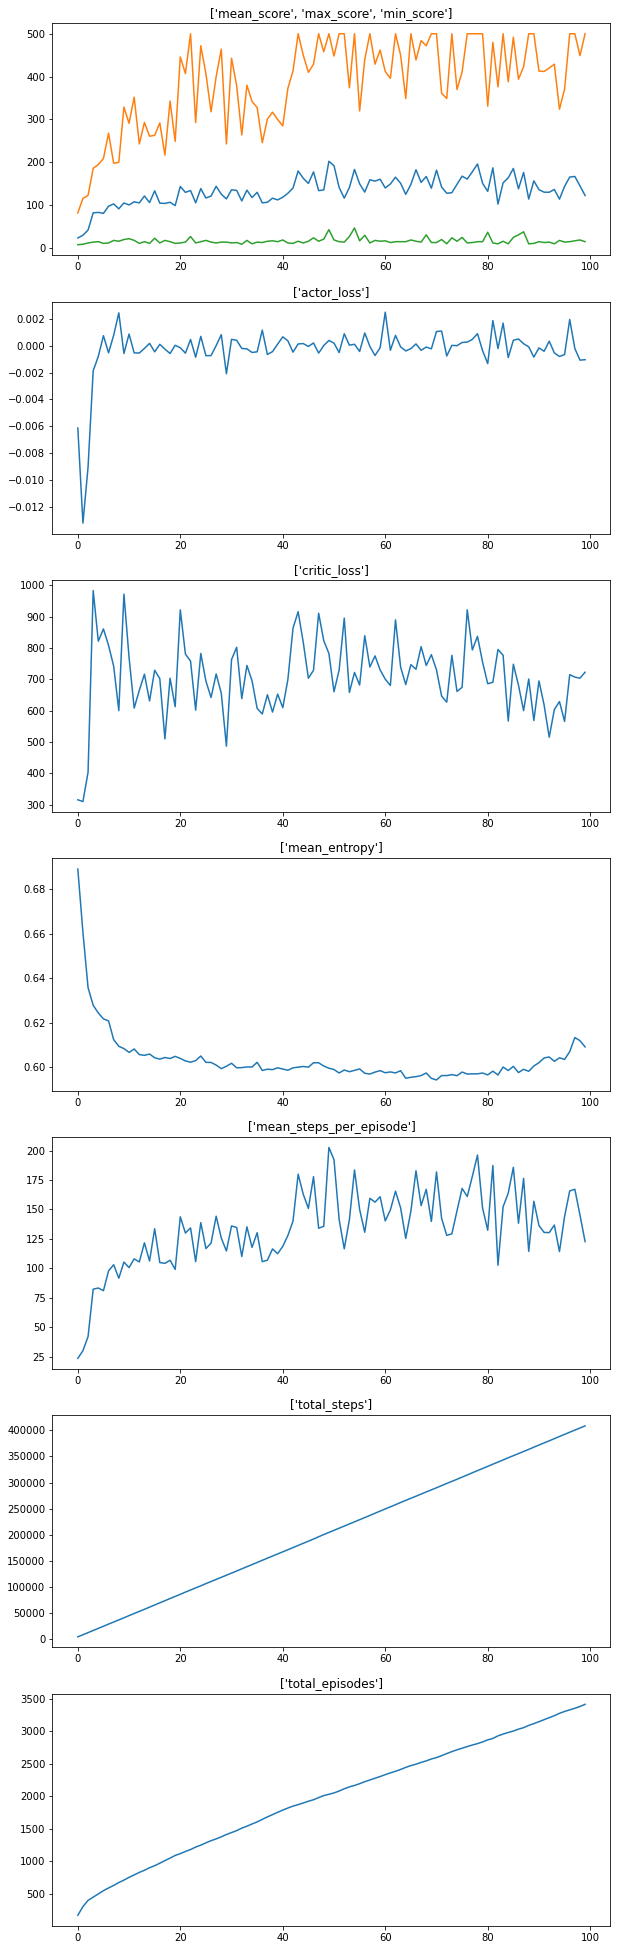

In [4]:
history = agent.run(
    plot_stats=[
        ['mean_score',
        'max_score',
        'min_score',],
        'actor_loss',
        'critic_loss',
        'mean_entropy',
        'mean_steps_per_episode',
        'total_steps',
        'total_episodes',
    ],
    history=history,
    plot_period=1,
)


# Testing PPO: Discrete LunarLander

In [7]:
ROOT_DIR = join("Experiments", "ppo_lunarlander_discrete")
agent = PPOAgent(
        config=dict(
            env_or_env_name="LunarLander-v2",
            logdir=join("Experiments", "ppo_lunarlander_discrete"),
            use_tensorboard=False,
            explore=True,
            clip_value=0.2,
            gamma=0.99,
            num_iter=1000,
            num_epochs=20,
            train_batch_size=4000,
            sgd_minibatch_size=128,
            num_dim_actor=(64, 64, 128),
            act_f_actor="tanh",
            num_dim_critic=(64, 64, 128),
            act_f_critic="relu",
            entropy_coeff=1e-3,
            lr=0.00025,
            vf_loss_coeff=1.0,
            vf_clip_param=10.0,
            clip_gradients_by_norm=0.5,
            use_critic=True,
            use_gae=True,
            gae_lambda=1.0,
            standardize_advantages=True,
        )
    )

history = {}

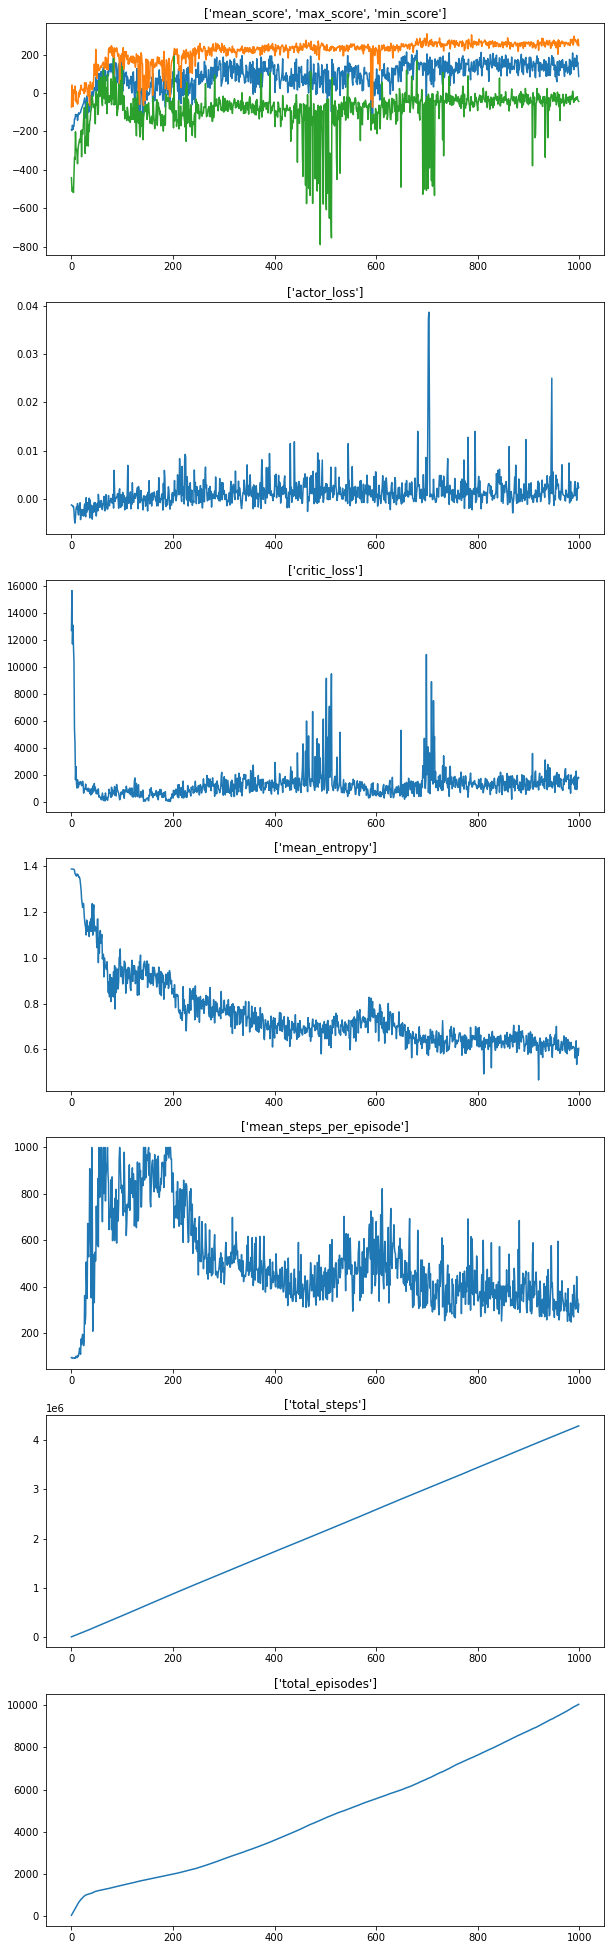

In [8]:
history = agent.run(
    plot_stats=[
        ['mean_score',
        'max_score',
        'min_score',],
        'actor_loss',
        'critic_loss',
        'mean_entropy',
        'mean_steps_per_episode',
        'total_steps',
        'total_episodes',
    ],
    history=history,
    plot_period=1,
)


In [15]:
from IPython.display import Video
import os

from gym.wrappers import Monitor
from policy_gradient.ppo import run_episode

ROOT_DIR = join("Experiments", "ppo_lunarlander_discrete")
video_path = join(ROOT_DIR, 'video')
eval_env = Monitor(
    agent.env,
    video_path,
    video_callable=lambda x: True,
    force=True,
)

run_episode(eval_env, agent)

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name))

# Continuous LunarLander

In [5]:
agent = PPOAgent(
        config=dict(
            env_or_env_name="LunarLanderContinuous-v2",
#             env_or_env_name="CartPole-v1",
            
            logdir=join("Experiments", "ppo_lunarlander"),
            use_tensorboard=False,
            explore=True,
            clip_value=0.2,
            gamma=0.99,
            num_iter=1000,
            num_epochs=20,
            train_batch_size=4000,
            sgd_minibatch_size=128,
            num_dim_actor=(64, 64, 128),
            act_f_actor="tanh",
            num_dim_critic=(64, 64, 128),
            act_f_critic="relu",
            entropy_coeff=1e-3,
            lr=0.00025,
            vf_loss_coeff=1.0,
            vf_clip_param=10.0,
            clip_gradients_by_norm=0.5,
            use_critic=True,
            use_gae=True,
            gae_lambda=1.0,
            standardize_advantages=True,
        )
    )

history = {}

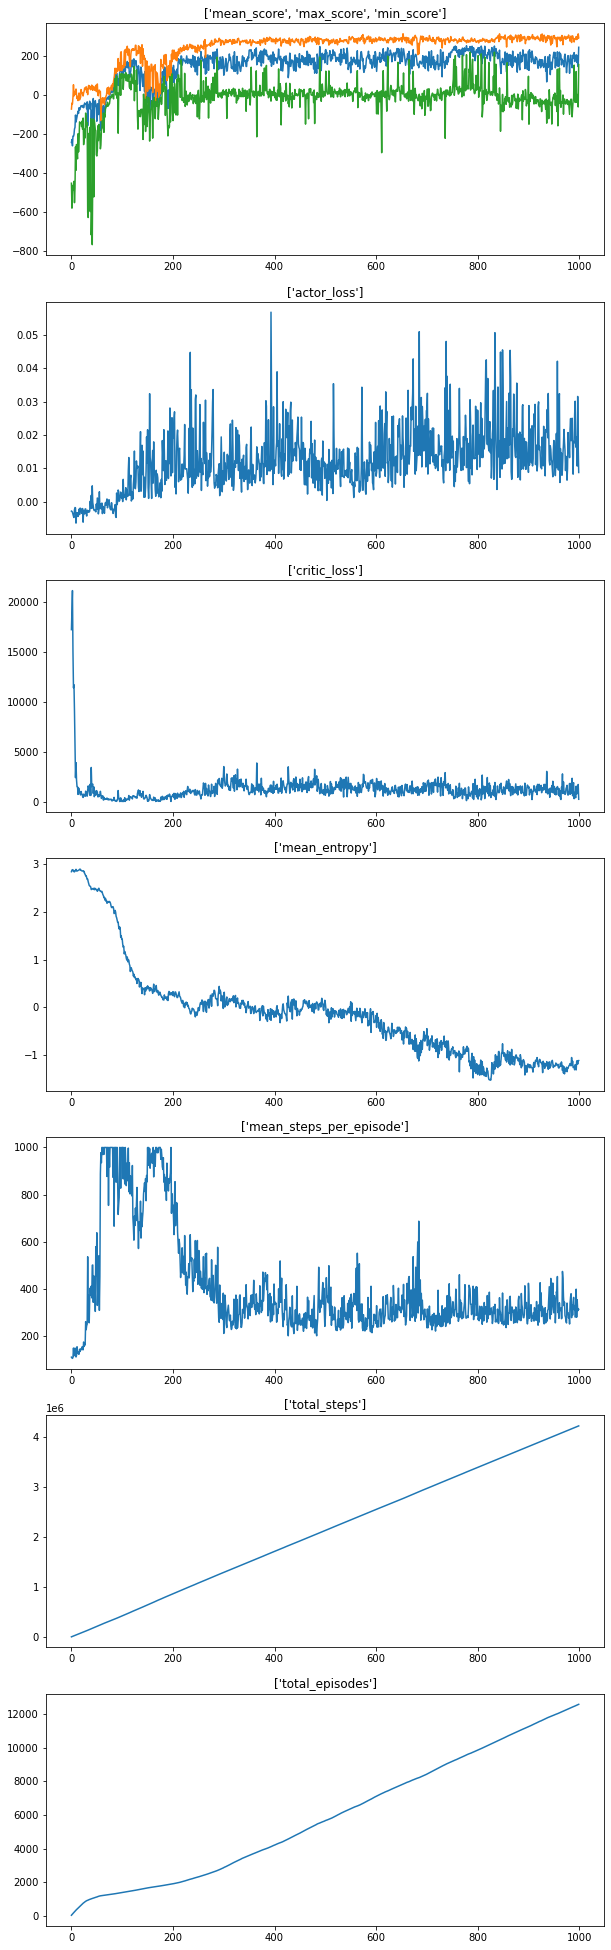

In [6]:
history = agent.run(
    plot_stats=[
        ['mean_score',
        'max_score',
        'min_score',],
        'actor_loss',
        'critic_loss',
        'mean_entropy',
        'mean_steps_per_episode',
        'total_steps',
        'total_episodes',
    ],
    history=history,
    plot_period=1,
)


In [10]:
from IPython.display import Video
import os

from gym.wrappers import Monitor
from policy_gradient.ppo import run_episode
video_path = join(join("Experiments", "ppo_lunarlander"), 'video')
eval_env = Monitor(
    agent.env,
    video_path,
    video_callable=lambda x: True,
    force=True,
)

run_episode(eval_env, agent)

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name))